In [1]:
from matplotlib import pyplot as plt
import cnn_utils as cnn
import pv_panel_utils
import tensorflow as tf
import numpy as np

%matplotlib inline

np.random.seed(42)

# Data Import

In [2]:
images, scores, labels, query_images, query_scores = pv_panel_utils.import_data()
print('Images and score masks successfully read.')

Images and score masks successfully read.


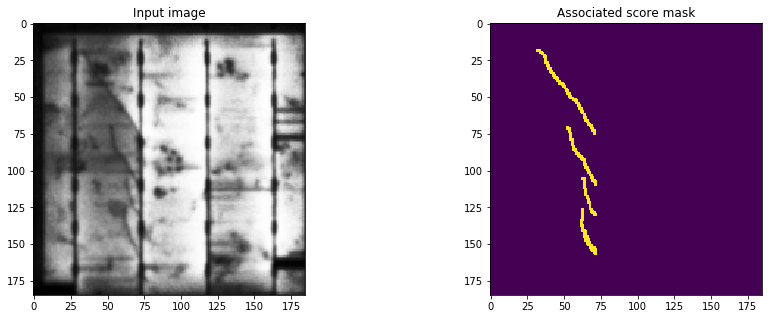

In [3]:
f, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].imshow(query_images[0, :, :, 0], cmap = 'gray'); axs[0].set_title('Input image')
axs[1].imshow(query_scores[0, :, :, 0]); axs[1].set_title('Associated score mask');

# Graph Definition

In [4]:
def define_variables(self):
    variables = {
                    'F0_1': cnn.BatchNormalizedConvLayer(1, 1, 8, residual_layer = False),
                    'F1_1': cnn.BatchNormalizedConvLayer(3, 8, 8, residual_layer = True),
                    'F1_2': cnn.BatchNormalizedConvLayer([40, 10], 8, 8, residual_layer = True),
                    'F2_1': cnn.BatchNormalizedConvLayer(3, 8, 16, residual_layer = False),
                    'F3_1': cnn.BatchNormalizedConvLayer(3, 16, 8, residual_layer = False),
                    'F4_1': cnn.BatchNormalizedConvLayer(5, 8, 8, residual_layer = True),
        
                    'S0_1': cnn.BatchNormalizedConvLayer(3, 8, 2, residual_layer = False),
                    'S1_1': cnn.BatchNormalizedConvLayer(3, 16, 2, residual_layer = False),
                    'S2_1': cnn.BatchNormalizedConvLayer(3, 16, 2, residual_layer = False),
                    'S3_1': cnn.BatchNormalizedConvLayer(3, 8, 2, residual_layer = False),
                    'S4_1': cnn.BatchNormalizedConvLayer(3, 8, 2, residual_layer = False),
        
                    'O5_1': cnn.BatchNormalizedConvLayer(16, 10, 10, residual_layer = True),
        
                    'O6_1': cnn.BatchNormalizedConvLayer(3, 10, 2, activate = False, residual_layer = False)
                }
    return variables

def W185_P52k_ResMask(self, mode, variables):
    """
        Defines sequences of operations constituting network. Refers to variables defined by <variables> dict.
    """
    # Input layer
    self.ops['F0_1'] = variables['F0_1'].apply(mode, self.images)
    self.ops['S0_1'] = variables['S0_1'].apply(mode, self.ops['F0_1'])
    
    # First layer
    self.ops['F1_1'] = variables['F1_1'].apply(mode, self.ops['F0_1'])
    self.ops['F1_2'] = variables['F1_2'].apply(mode, self.ops['F0_1']) # Tall conv.
    self.ops['C1_1'] = tf.concat([self.ops['F1_1'], self.ops['F1_2']], axis = -1)
    self.ops['S1_1'] = variables['S1_1'].apply(mode, self.ops['C1_1'])
    
    # Second Layer
    self.ops['F2_1'] = variables['F2_1'].apply(mode, self.ops['F1_1'])
    self.ops['S2_1'] = variables['S2_1'].apply(mode, self.ops['F2_1'])
    
    # Third layer
    self.ops['F3_1'] = variables['F3_1'].apply(mode, self.ops['F2_1'])
    self.ops['S3_1'] = variables['S3_1'].apply(mode, self.ops['F3_1'])
    
    # Fourth layer
    self.ops['F4_1'] = variables['F4_1'].apply(mode, self.ops['F3_1'])
    self.ops['S4_1'] = variables['S4_1'].apply(mode, self.ops['F4_1'])
    
    # Combining of all skip layers : x8 16 x 16 x 6 filters
    self.ops['C5_1'] = tf.concat([ self.ops['S0_1'], self.ops['S1_1'], self.ops['S2_1'],
                                   self.ops['S3_1'], self.ops['S4_1']], axis = -1)
    
    self.ops['O5_1'] = variables['O5_1'].apply(mode, self.ops['C5_1'])
    
    # Logit layer
    self.ops['logits'] = variables['O6_1'].apply(mode, self.ops['O5_1'])
    
    return self.ops['logits']

# Training

In [5]:
model = cnn.CNNModel(define_variables, W185_P52k_ResMask, model_id = 'W185_P52k_ResMask')
model.compile_graph()
model.train(batch_size = 16,
            training_steps = 10001,
            training_images = images,
            training_scores = scores,
            training_labels = labels,
            query_images = query_images,
            query_scores = query_scores)

Training initialized.


Mean minibatch cross-entropy @ step  100 : 0.690
Mean minibatch cross-entropy @ step  200 : 0.685
Mean minibatch cross-entropy @ step  300 : 0.674
Mean minibatch cross-entropy @ step  400 : 0.654
Mean minibatch cross-entropy @ step  500 : 0.632
Mean minibatch cross-entropy @ step  600 : 0.613
Mean minibatch cross-entropy @ step  700 : 0.595
Mean minibatch cross-entropy @ step  800 : 0.577
Mean minibatch cross-entropy @ step  900 : 0.559
Mean minibatch cross-entropy @ step 1000 : 0.539
Mean minibatch cross-entropy @ step 1100 : 0.529
Mean minibatch cross-entropy @ step 1200 : 0.494
Mean minibatch cross-entropy @ step 1300 : 0.467
Mean minibatch cross-entropy @ step 1400 : 0.446
Mean minibatch cross-entropy @ step 1500 : 0.427
Mean minibatch cross-entropy @ step 1600 : 0.390
Mean minibatch cross-entropy @ step 1700 : 0.368
Mean minibatch cross-entropy @ step 1800 : 0.347
Mean minibatch cross-entropy @ step 1900 : 0.325
Mean minibatch cross-entropy @ step 2000 : 0.